In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import pathlib

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten,Activation, BatchNormalization,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [19]:
## Establecemos el directorio donde están las imágenes
data_dir = pathlib.Path("PetImages")

dogs = list(data_dir.glob('Dog/*'))[:6000]

cats = list(data_dir.glob('Cat/*'))[:6000]

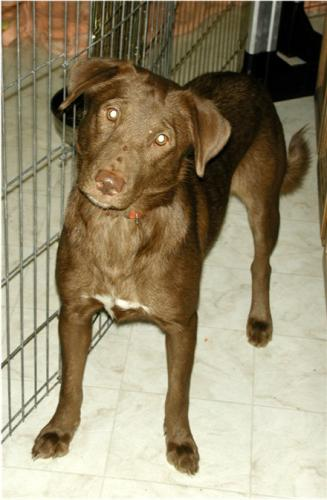

In [20]:
PIL.Image.open(str(dogs[1]))

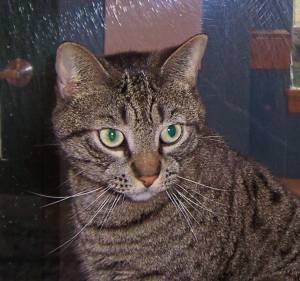

In [21]:
PIL.Image.open(str(cats[1]))

In [22]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

25000


In [23]:
pet_images_dict = {
    'cats': list(data_dir.glob('Cat/*'))[:6000],
    'dogs': list(data_dir.glob('Dog/*'))[:6000],
}

pet_labels_dict = {
    'cats': 0,
    'dogs': 1,
}

In [24]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
X, Y = [], []

for pet_name, images in pet_images_dict.items():
    print(pet_name)
    for image in images:
        img = cv2.imread(str(image))
        if isinstance(img,type(None)): 
            #print('image not found')
            continue
            
        elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
            resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
            X.append(resized_img)
            Y.append(pet_labels_dict[pet_name])
        else:
            #print("Invalid Image")
            continue


cats
dogs


In [25]:
X = np.array(X)
Y = np.array(Y)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
print(len(X_train),len(Y_train))
print(len(X_test),len(Y_test))

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

8808 8808
2937 2937
(8808, 128, 128, 3) (8808,)
(2937, 128, 128, 3) (2937,)


## Asegurar el balanceo de las muestras

In [30]:
class_counts = dict(zip(*np.unique(Y_train, return_counts=True)))

majority_class = max(class_counts, key=class_counts.get)
minority_class = min(class_counts, key=class_counts.get)

majority_indices = np.where(Y_train == majority_class)[0]
minority_indices = np.where(Y_train == minority_class)[0]

In [32]:
num_minority_samples = len(minority_indices)
random_majority_indices = np.random.choice(majority_indices, num_minority_samples, replace=False)

undersampled_indices = np.concatenate([random_majority_indices, minority_indices])

In [37]:
X_train_resampled = X_train[undersampled_indices]
Y_train_resampled = Y_train[undersampled_indices]

In [39]:
print(len(X_train_resampled),len(Y_train_resampled))
print(len(X_test),len(Y_test))

print(X_train_resampled.shape,Y_train_resampled.shape)
print(X_test.shape,Y_test.shape)

8748 8748
2937 2937
(8748, 128, 128, 3) (8748,)
(2937, 128, 128, 3) (2937,)


## Build convolutional neural network and train it

In [40]:
IMAGE_CHANNELS=3
model = Sequential([

Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Conv2D(128, (3, 3), activation='relu'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),

Flatten(),
Dense(512, activation='relu'),
BatchNormalization(),
Dropout(0.5),
Dense(1, activation='sigmoid'), # 2 because we have cat and dog classes
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 61, 61, 64)       

In [43]:
history=model.fit(X_train_resampled, Y_train_resampled, epochs=10)

Epoch 1/10
274/274 [==============================] - 260s 949ms/step - loss: 0.2313 - accuracy: 0.9049
Epoch 2/10
274/274 [==============================] - 272s 994ms/step - loss: 0.2378 - accuracy: 0.9009
Epoch 3/10
274/274 [==============================] - 272s 993ms/step - loss: 0.2065 - accuracy: 0.9171
Epoch 4/10
274/274 [==============================] - 269s 983ms/step - loss: 0.1803 - accuracy: 0.9313
Epoch 5/10
274/274 [==============================] - 12617s 46s/step - loss: 0.1559 - accuracy: 0.9428
Epoch 6/10
274/274 [==============================] - 270s 986ms/step - loss: 0.1798 - accuracy: 0.9278
Epoch 7/10
274/274 [==============================] - 271s 989ms/step - loss: 0.1538 - accuracy: 0.9402
Epoch 8/10
274/274 [==============================] - 271s 989ms/step - loss: 0.1085 - accuracy: 0.9592
Epoch 9/10
274/274 [==============================] - 271s 990ms/step - loss: 0.0992 - accuracy: 0.9622
Epoch 10/10
274/274 [==============================] - 271s 990m

In [44]:
model.evaluate(X_test,Y_test)

92/92 [==============================] - 20s 221ms/step - loss: 0.7608 - accuracy: 0.7736


[0.7607582211494446, 0.7735784649848938]

In [45]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred = model.predict(X_test)
y_pred_classes = [0 if element < 0.5 else 1 for element in y_pred]

print("Classification Report: \n", classification_report(Y_test, y_pred_classes))

92/92 [==============================] - 19s 203ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.65      0.75      1496
           1       0.71      0.90      0.80      1441

    accuracy                           0.77      2937
   macro avg       0.79      0.78      0.77      2937
weighted avg       0.79      0.77      0.77      2937



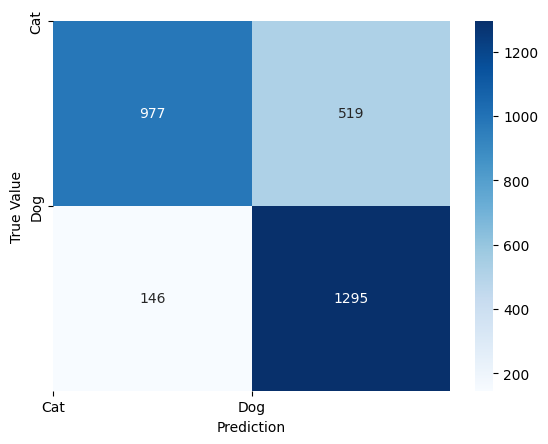

In [46]:
import seaborn as sns
cm = confusion_matrix(Y_test, y_pred_classes)

class_names = ['Cat', 'Dog']

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.yticks(ticks=range(len(class_names)), labels=class_names)

plt.ylabel('True Value')
plt.xlabel('Prediction')
plt.show()

In [47]:
## Evaluate the model

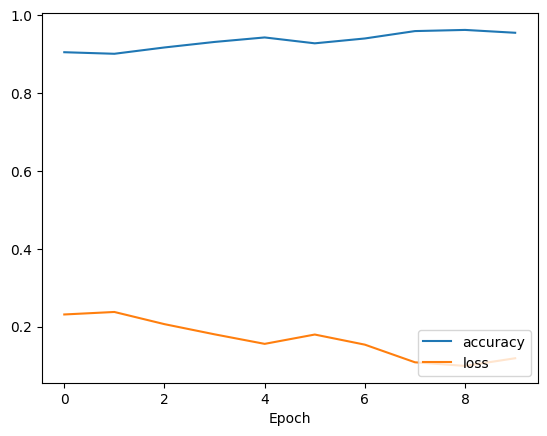

In [48]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [49]:
## Predict

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2724\3798822697.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  fileImage = Image.open("Maya.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)


1/1 [==============================] - 0s 78ms/step
[[0.90240574]]
class: 1 name= dog


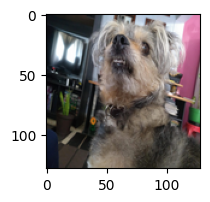

In [52]:
classes = ["cat","dog"]
from PIL import Image
fileImage = Image.open("Maya.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)
image = np.array(fileImage)
myimage = image.reshape(1, IMAGE_WIDTH,IMAGE_HEIGHT,3)
# prepare pixel data
#myimage = myimage.astype('float32')
#myimage = myimage/255.
plt.figure(figsize = (4,2))
plt.imshow(image)

my_predicted_image = model.predict(myimage)
print(my_predicted_image)
if (my_predicted_image < 0.40):
    y_class=0 
else:
    y_class=1
print("class:",y_class,"name=",classes[y_class])

## Nuestras mascotas

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2724\366839870.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  fileImage = Image.open("kira.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)


1/1 [==============================] - 0s 71ms/step
[[0.88084835]]
class: 1 name= dog


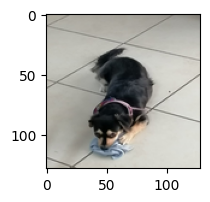

In [58]:
classes = ["cat","dog"]
from PIL import Image
fileImage = Image.open("kira.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)
image = np.array(fileImage)
myimage = image.reshape(1, IMAGE_WIDTH,IMAGE_HEIGHT,3)
# prepare pixel data
#myimage = myimage.astype('float32')
#myimage = myimage/255.
plt.figure(figsize = (4,2))
plt.imshow(image)

my_predicted_image = model.predict(myimage)
print(my_predicted_image)
if (my_predicted_image < 0.40):
    y_class=0 
else:
    y_class=1
print("class:",y_class,"name=",classes[y_class])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2724\1640238399.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  fileImage = Image.open("brucci.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)


1/1 [==============================] - 0s 59ms/step
[[0.8047513]]
class: 1 name= dog


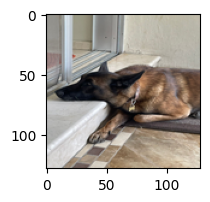

In [57]:
classes = ["cat","dog"]
from PIL import Image
fileImage = Image.open("brucci.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)
image = np.array(fileImage)
myimage = image.reshape(1, IMAGE_WIDTH,IMAGE_HEIGHT,3)
# prepare pixel data
#myimage = myimage.astype('float32')
#myimage = myimage/255.
plt.figure(figsize = (4,2))
plt.imshow(image)

my_predicted_image = model.predict(myimage)
print(my_predicted_image)
if (my_predicted_image < 0.40):
    y_class=0 
else:
    y_class=1
print("class:",y_class,"name=",classes[y_class])

1/1 [==============================] - 0s 40ms/step
[[0.46579885]]
class: 1 name= dog


C:\Users\Usuario\AppData\Local\Temp\ipykernel_2724\3973247619.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  fileImage = Image.open("bubaldo.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)


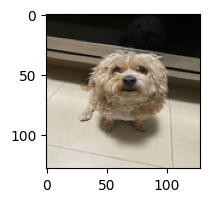

In [60]:
classes = ["cat","dog"]
from PIL import Image
fileImage = Image.open("bubaldo.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)
image = np.array(fileImage)
myimage = image.reshape(1, IMAGE_WIDTH,IMAGE_HEIGHT,3)
# prepare pixel data
#myimage = myimage.astype('float32')
#myimage = myimage/255.
plt.figure(figsize = (4,2))
plt.imshow(image)

my_predicted_image = model.predict(myimage)
print(my_predicted_image)
if (my_predicted_image < 0.40):
    y_class=0 
else:
    y_class=1
print("class:",y_class,"name=",classes[y_class])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2724\2469236600.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  fileImage = Image.open("burbuja.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)


1/1 [==============================] - 0s 65ms/step
[[0.00516337]]
class: 0 name= cat


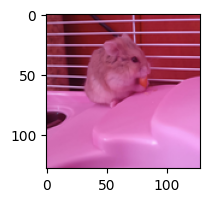

In [55]:
classes = ["cat","dog"]
from PIL import Image
fileImage = Image.open("burbuja.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)
image = np.array(fileImage)
myimage = image.reshape(1, IMAGE_WIDTH,IMAGE_HEIGHT,3)
# prepare pixel data
#myimage = myimage.astype('float32')
#myimage = myimage/255.
plt.figure(figsize = (4,2))
plt.imshow(image)

my_predicted_image = model.predict(myimage)
print(my_predicted_image)
if (my_predicted_image < 0.40):
    y_class=0 
else:
    y_class=1
print("class:",y_class,"name=",classes[y_class])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2724\1924544747.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  fileImage = Image.open("negri.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)


1/1 [==============================] - 0s 62ms/step
[[0.00085378]]
class: 0 name= cat


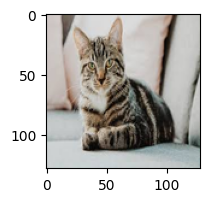

In [59]:
classes = ["cat","dog"]
from PIL import Image
fileImage = Image.open("negri.jpeg").convert("RGB").resize([IMAGE_WIDTH,IMAGE_HEIGHT],Image.ANTIALIAS)
image = np.array(fileImage)
myimage = image.reshape(1, IMAGE_WIDTH,IMAGE_HEIGHT,3)
# prepare pixel data
#myimage = myimage.astype('float32')
#myimage = myimage/255.
plt.figure(figsize = (4,2))
plt.imshow(image)

my_predicted_image = model.predict(myimage)
print(my_predicted_image)
if (my_predicted_image < 0.40):
    y_class=0 
else:
    y_class=1
print("class:",y_class,"name=",classes[y_class])